In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
with open("../results/logreg_metrics.json") as f:
    logreg = json.load(f)

with open("../results/nn_metrics.json") as f:
    nn = json.load(f)

with open("../results/distilbert_metrics.json") as f:
    bert = json.load(f)

df = pd.DataFrame([
    {"Model": "LogReg + TF-IDF", **logreg},
    {"Model": "Simple NN (PyTorch)", **nn},
    {"Model": "DistilBERT (fine-tuning)", **bert},
])

df

,Model,val_accuracy,val_f1_macro,test_accuracy,test_f1_macro
0,LogReg + TF-IDF,0.918444,0.918243,0.914868,0.914667
1,Simple NN (PyTorch),0.913944,0.913821,0.912368,0.912248
2,DistilBERT (fine-tuning),0.948722,0.948735,0.945526,0.945579


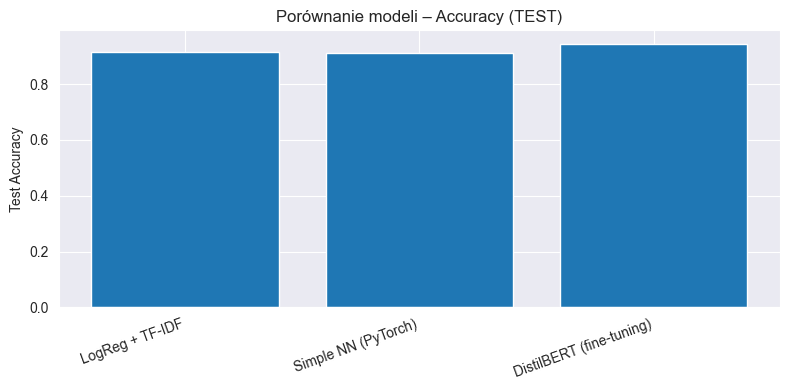

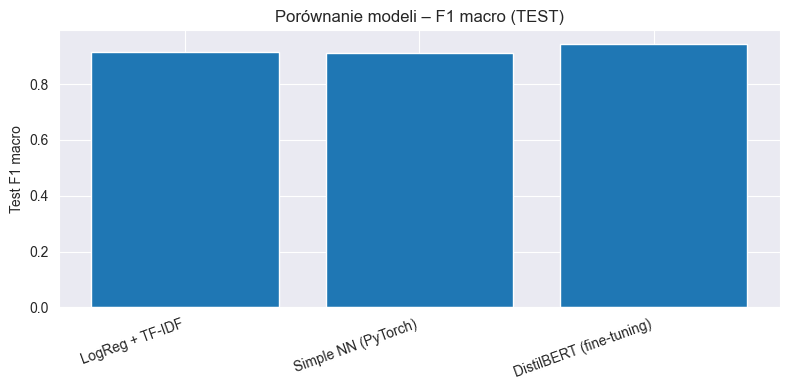

In [3]:
plt.figure(figsize=(8,4))
plt.bar(df["Model"], df["test_accuracy"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("Test Accuracy")
plt.title("Porównanie modeli – Accuracy (TEST)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.bar(df["Model"], df["test_f1_macro"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("Test F1 macro")
plt.title("Porównanie modeli – F1 macro (TEST)")
plt.tight_layout()
plt.show()

In [4]:
import joblib

tfidf_data = joblib.load("../data/processed/tfidf_data.joblib")
X_test_tfidf = tfidf_data["X_test"]
y_test = np.array(tfidf_data["y_test"])

logreg_model = joblib.load("../models/logreg_tfidf.joblib")
pred_logreg = logreg_model.predict(X_test_tfidf)

In [5]:
import torch
from torch import nn

seq_data = joblib.load("../data/processed/sequence_data.joblib")
X_test_seq = torch.tensor(seq_data["X_test_seq"], dtype=torch.long)
y_test_seq = np.array(seq_data["y_test"])

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

class SimpleTextNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        pooled = emb.mean(dim=1)
        h = torch.relu(self.fc1(pooled))
        h = self.dropout(h)
        return self.fc2(h)

vocab_size = 20000
nn_model = SimpleTextNN(vocab_size=vocab_size).to(device)
nn_model.load_state_dict(torch.load("../models/simple_text_nn.pt", map_location="cpu"))
nn_model.eval()

with torch.no_grad():
    logits = nn_model(X_test_seq.to(device))
    pred_nn = logits.argmax(dim=1).cpu().numpy()

In [6]:
from transformers import pipeline

clf = pipeline(
    "text-classification",
    model="../models/distilbert_finetuned_agnews",
    tokenizer="../models/distilbert_finetuned_agnews",
    device=0 if torch.backends.mps.is_available() else -1
)

/Users/GruszkaStudent/pjatk(Engineer)/ZUM/ZUM_2025_DanielGruszkowski/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


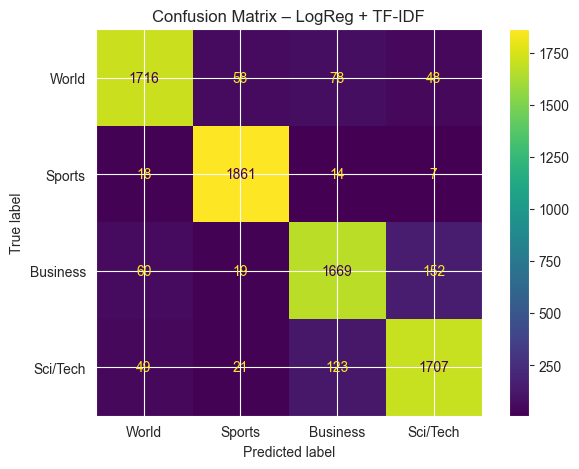

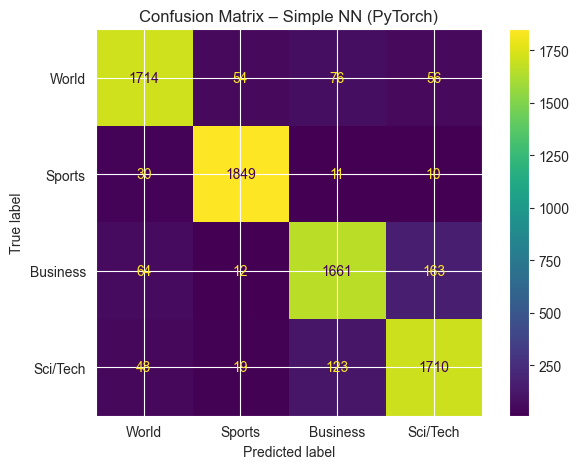

In [7]:
labels = ["World", "Sports", "Business", "Sci/Tech"]

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(values_format="d")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_cm(y_test, pred_logreg, "Confusion Matrix – LogReg + TF-IDF")
plot_cm(y_test_seq, pred_nn, "Confusion Matrix – Simple NN (PyTorch)")